### I. Identify the device and region on which to measure volume

<div>
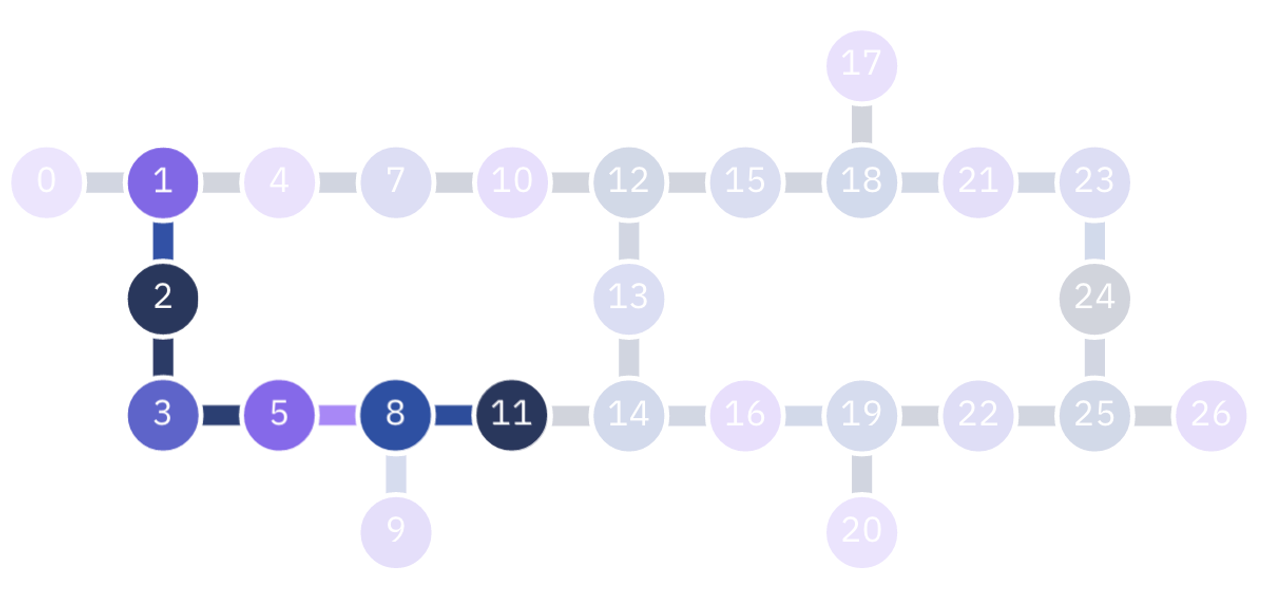
</div>

In [1]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.providers(hub='ibm-q-internal', group='performance', project='default-params')[0]
backend = provider.backend.ibm_hanoi

In [2]:
from qiskit.transpiler import InstructionDurations, CouplingMap

qubit_subset = [1, 2, 3, 5, 8, 11]

coupling_map = CouplingMap(backend.configuration().coupling_map)
basis_gates = backend.configuration().basis_gates
dt = backend.configuration().dt

instruction_durations = InstructionDurations.from_backend(backend)

### II. Load pre-mapped circuits

If you do not have access to a full CPLEX license or if you want to speed up the compilation process, you can load pre-mapped circuits and set `do_mapping=False` below. If you are using the same qubit connecitivity topology, this can be a good way to skip the CPLEX optimization part of compilation, since the mapping problem is dependent only on the topology. Setting `do_mapping=True` will do the entire compilation flow in Qiskit.

In [8]:
do_mapping = False

In [ ]:
from qiskit.circuit import qpy_serialization
with open('qv64_original.qpy', 'rb') as f:
    model_circuits = qpy_serialization.load(f)
with open('qv64_bip_line_approx99.qpy', 'rb') as f:
    model_circuits_mapped = qpy_serialization.load(f)

### II. Build a custom passmanager that will do the desired circuit mapping and optimizations

In [4]:
# a custom passmanager that does the compilation of QV circuits
from qiskit.circuit import QuantumRegister
from qiskit.circuit.library import XGate
from qiskit.transpiler import PassManager, Layout
from qiskit.transpiler.passes import (BIPMapping,
                                      Depth, 
                                      FixedPoint,
                                      Collect2qBlocks, 
                                      ConsolidateBlocks,
                                      UnitarySynthesis, 
                                      Optimize1qGatesDecomposition, 
                                      CommutativeCancellation, 
                                      SetLayout, 
                                      FullAncillaAllocation, 
                                      EnlargeWithAncilla, 
                                      ApplyLayout,
                                      ALAPSchedule,
                                      DynamicalDecoupling)

def qv_passmanager(basis_gates, coupling_map, qubit_subset, backend_props,
                   instruction_durations, synthesis_fidelity=1., pulse_optimize=True, do_mapping=False):
    
    def _repeat_condition(property_set):
        return not property_set['depth_fixed_point']
    
    sub_coupling_map = coupling_map.reduce(qubit_subset)
    qr = QuantumRegister(size=len(qubit_subset), name='q')
    layout = Layout.from_intlist(sorted(qubit_subset), qr)

    _map = [BIPMapping(sub_coupling_map, objective='depth', time_limit=100)]

    _embed = [SetLayout(layout),
              FullAncillaAllocation(coupling_map),
              EnlargeWithAncilla(),
              ApplyLayout()]

    _check_depth = [Depth(),
                    FixedPoint('depth')]

    _optimize = [
        Collect2qBlocks(),
        ConsolidateBlocks(basis_gates=basis_gates),
        UnitarySynthesis(basis_gates, synthesis_fidelity, coupling_map, backend_props,
                         pulse_optimize=True, natural_direction=True),
        Optimize1qGatesDecomposition(basis_gates)
    ]

    _schedule = [
        ALAPSchedule(instruction_durations),
        DynamicalDecoupling(instruction_durations, dd_sequence=[XGate(), XGate()])
    ]

    pm = PassManager()
    if do_mapping:
        pm.append(_map)                    # map to a subset of qubits, by choosing layout and inserting swaps
    pm.append(_embed)                      # embed the mapped circuit onto the larger device coupling map
    pm.append(_check_depth + _optimize,
              do_while=_repeat_condition)  # translate to & optimize over hardware native gates
    pm.append(_schedule)                   # dynamical decoupling on an as-late-as-possible schedule
    return pm

In [6]:
pm = qv_passmanager(basis_gates=basis_gates,
                    coupling_map=coupling_map,
                    qubit_subset=qubit_subset,
                    backend_props=backend.properties(),
                    instruction_durations=instruction_durations,
                    synthesis_fidelity=.99,
                    pulse_optimize=True,
                    do_mapping=False)

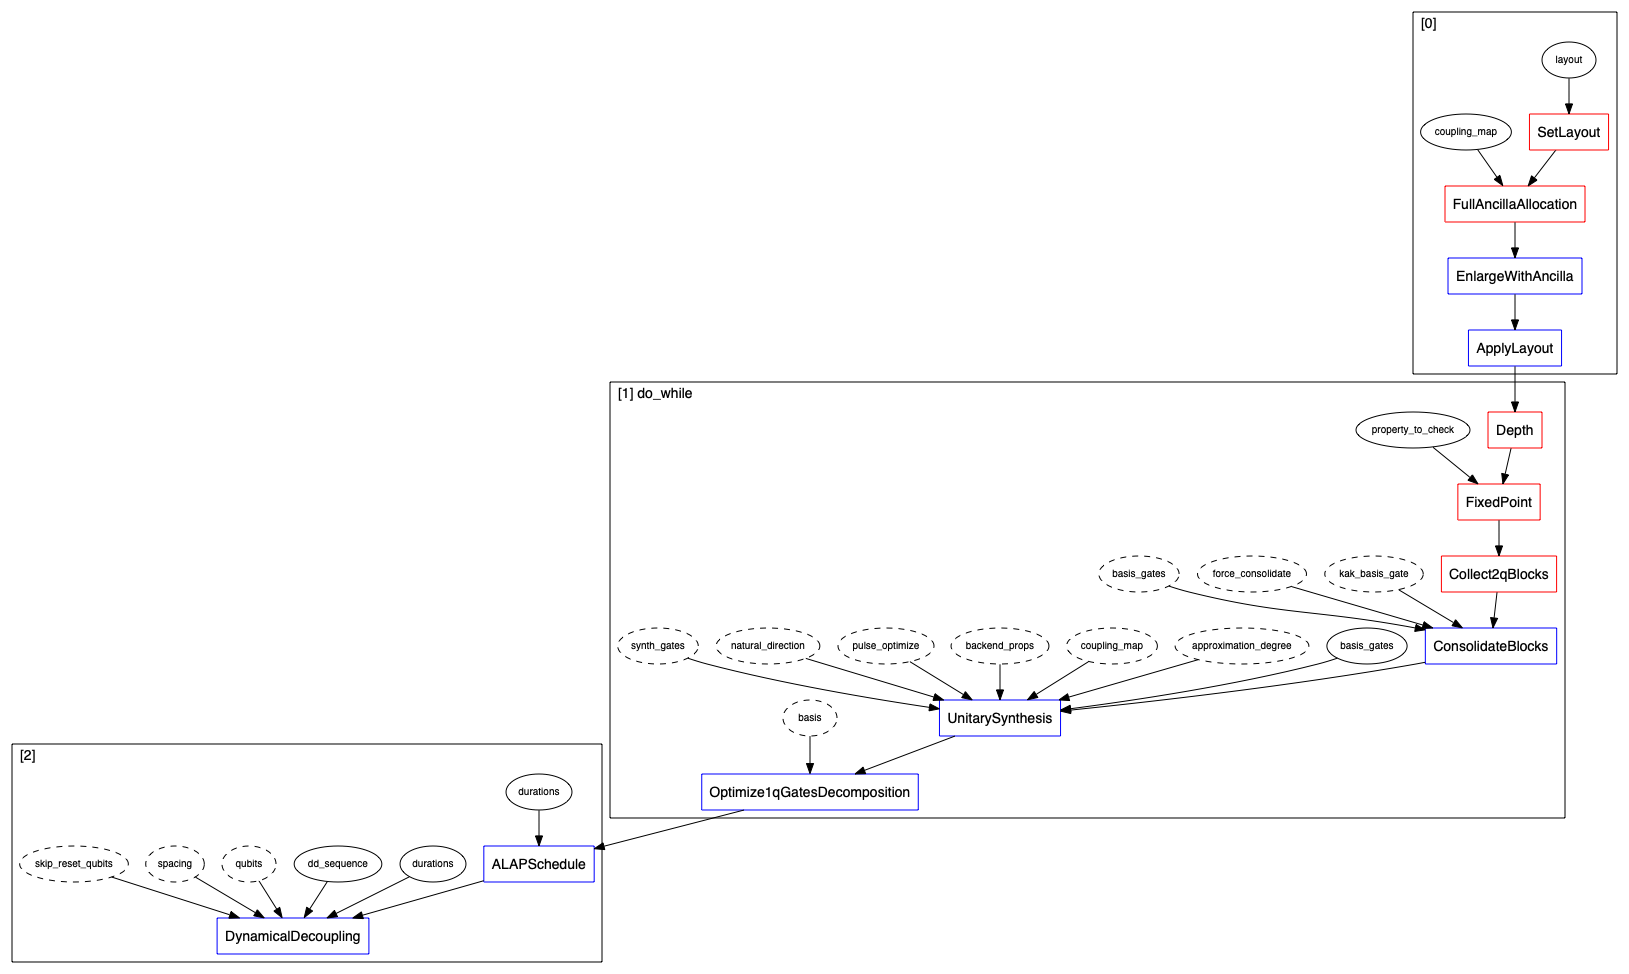

In [7]:
# optional: visualize the passmanager to see the passes invoked
pm.draw()

### IV. Compile 100 model circuits and plot distribution of resources

In [9]:
N = 100

In [11]:
from qiskit.circuit.library import QuantumVolume

# build fresh quantum volume model circuits if not using pre-mapped circuits
if do_mapping:
    model_circuits = [QuantumVolume(num_qubits, seed=i).decompose() for i in range(N)]
    model_circuits_measured = [circuit.measure_all(inplace=False) for circuit in model_circuits]

In [12]:
from tqdm import tqdm

model_circuits_compiled = []

if do_mapping:
    for circuit in tqdm(model_circuits_measured):
        model_circuits_compiled.append(pm.run(circuit))
else:
    for circuit in tqdm(model_circuits_mapped[:N]):
        model_circuits_compiled.append(pm.run(circuit))

100%|██████████| 100/100 [00:46<00:00,  2.13it/s]


array([<AxesSubplot:title={'center':'cx\nmean: 56.9    median: 57.0\nmin: 26     max: 78'}>,
       <AxesSubplot:title={'center':'sx\nmean: 144.6    median: 144.0\nmin: 78     max: 180'}>,
       <AxesSubplot:title={'center':'duration\nmean: 9929.4    median: 10335.5\nmin: 4899     max: 11185'}>],
      dtype=object)

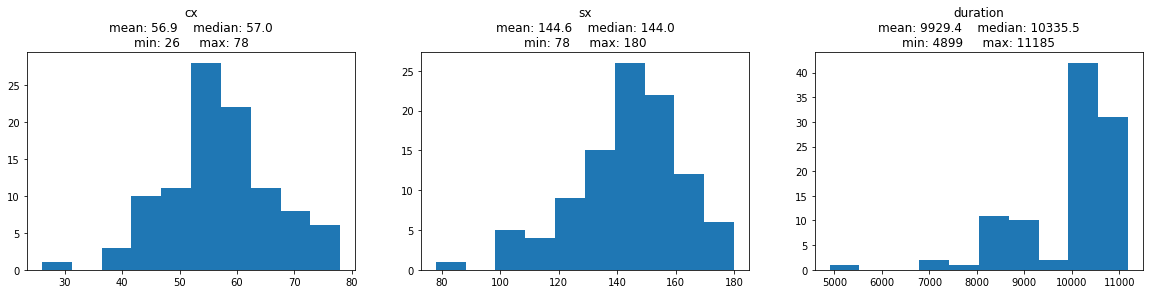

In [13]:
from qv_tools import plot_resources
plot_resources(model_circuits_compiled, dt)

### III. Optional: Inspect compiler output for a single model circuit

In [14]:
model_circuit = model_circuits[0]
model_circuit_mapped = model_circuits_mapped[0]
model_circuit_compiled = pm.run(model_circuit_mapped)
print(f"num cx: {model_circuit_compiled.count_ops().get('cx', 0)}")
print(f"num sx: {model_circuit_compiled.count_ops().get('sx', 0)}")
print(f"num x: {model_circuit_compiled.count_ops().get('x', 0)}")
print(f"depth: {model_circuit_compiled.depth()}")
print(f"duration: {model_circuit_compiled.duration * dt * 1e6} us")

num cx: 62
num sx: 156
num x: 42
depth: 155
duration: 10.79111111111111 us


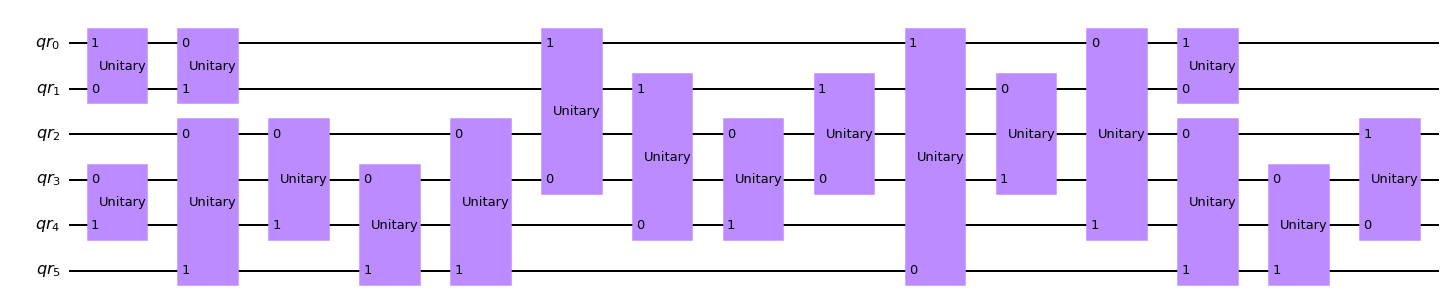

In [15]:
model_circuit.draw('mpl', fold=-1)

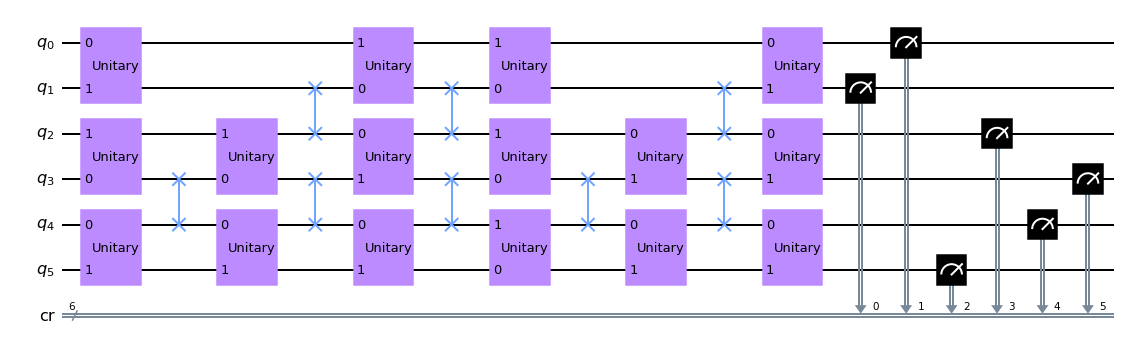

In [16]:
model_circuit_mapped = model_circuits_mapped[0]
model_circuit_mapped.draw('mpl', fold=-1)

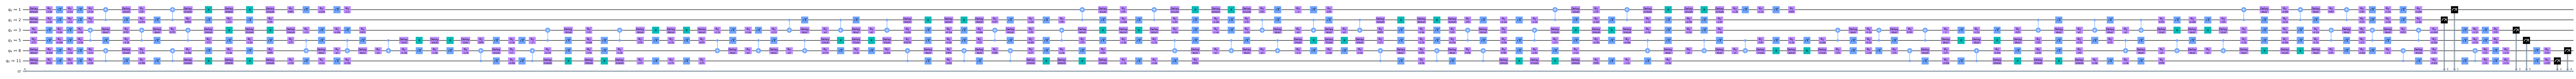

In [17]:
model_circuit_compiled.draw('mpl', fold=-1, idle_wires=False)

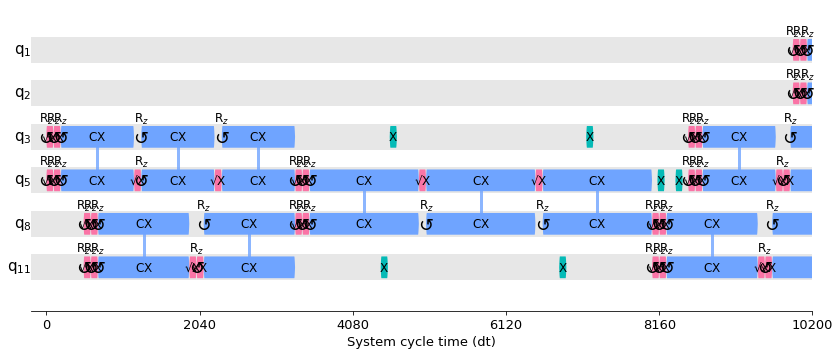

In [18]:
from qiskit.visualization import timeline_drawer
timeline_drawer(model_circuit_compiled, time_range=(0, 10000), show_idle=False)

### V. Run experiments and compute HOPs

In [19]:
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel
fake_backend = AerSimulator()

In [20]:
shots = 2000
job_exp = backend.run(model_circuits_compiled, shots=shots)
job_sim = fake_backend.run(model_circuits_compiled, shots=shots)

In [ ]:
# optional: inquire about job status
#print('status: ', job_exp.status())
#print('queue position: ', job_exp.queue_position())
#print('job id: ', job_exp.job_id())

In [21]:
from qv_tools import get_ideal_probabilities, get_heavy_strings, hop

hops_exp = []
hops_sim = []

res_sim = job_sim.result()
res_exp = job_exp.result()

for model_circuit in model_circuits[:N]:
    ideal_probs = get_ideal_probabilities(model_circuit)
    median, heavy_strings = get_heavy_strings(ideal_probs)

    counts_exp = res_exp.get_counts(model_circuit)
    counts_sim = res_sim.get_counts(model_circuit)

    hops_exp.append(hop(counts_exp, ideal_probs))
    hops_sim.append(hop(counts_sim, ideal_probs))

<AxesSubplot:xlabel='Number of Trials', ylabel='Heavy Output Probability'>

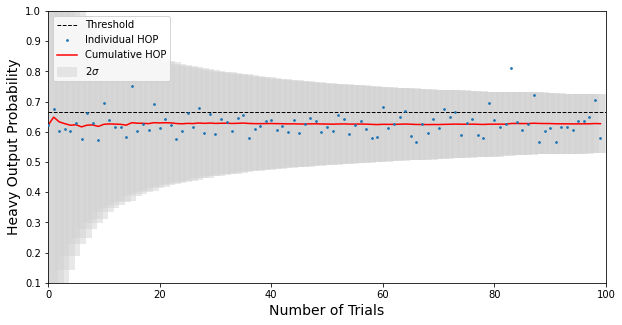

In [22]:
from qv_tools import plot_hop_accumulative
plot_hop_accumulative(hops_exp)

<AxesSubplot:xlabel='Number of Trials', ylabel='Heavy Output Probability'>

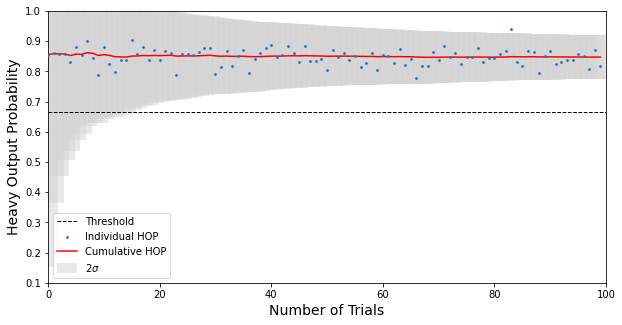

In [23]:
# HOP from ideal simulation
plot_hop_accumulative(hops_sim)

This notebook has been written in a self-contained way, in order to demonstrate the capabilities of the compiler and the faster gates. The `qiskit-experiments` framework includes more bells and whistles for running quantum volume experiments, as well as other experiments.